# (30) fit iterative pvae w/o whitening

**Motivation**: This one is truely iterative, with ```#iters=3```. host = ```mach```, device = ```cuda:1``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick

device_idx = 1
device = f'cuda:{device_idx}'

## Fit one model

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('vH16', model_type, 'lin|lin')
cfg_vae['seq_len'] = 3
cfg_tr['file_name'] = 'patches.npy'

print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'vH16', 'n_latents': 512, 'prior_clamp': -4, 'fit_prior': True, 'enc_type': 'lin', 'dec_type': 'lin', 
'enc_bias': False, 'dec_bias': False, 'init_dist': 'normal', 'init_scale': 0.05, 'seq_len': 3}

Trainer:
{'lr': 0.005, 'batch_size': 1000, 'epochs': 3000, 'optimizer_kws': {'weight_decay': 0.0}, 'grad_clip': 500, 
'kl_const_portion': 0.0, 'file_name': 'patches.npy'}

### Make model + trainer

In [4]:
vae = HIPVAE(CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

### Make sure it's raw patches

In [5]:
x_all = tr.dl_vld.dataset.tensors[0]

mu = tonp(torch.mean(x_all, -1))
var = tonp(torch.var(x_all, -1))
norms = tonp(torch.linalg.vector_norm(x_all, dim=-1))

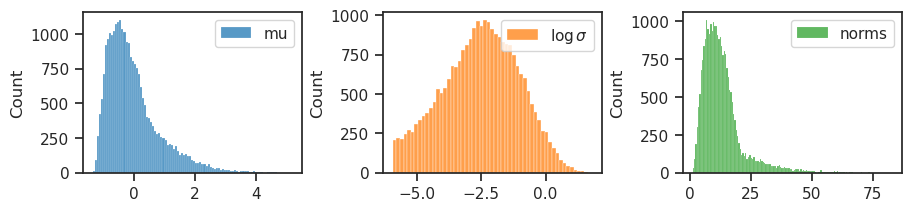

In [6]:
fig, axes = create_figure(1, 3)
sns.histplot(mu, color='C0', label='mu', ax=axes[0])
sns.histplot(np.log(var), color='C1', label=r'$\log \sigma$', ax=axes[1])
sns.histplot(norms, color='C2', label='norms', ax=axes[2])
add_legend(axes)
plt.show()

### Print info

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    HIPVAE   |  262.7 K   |
|     ———     |    ———     |
|  layers.L_0 |  262.7 K   |
+-------------+------------+

poisson_uniform_c(-4)_vH16_t-3_z-[512]_fp_nrm-none_<lin|lin>
mc_b1000-ep3000-lr(0.005)_beta(1:0x0.5)_temp(0.1:lin-0.5)_gr(500)_(2024_07_30,18:48)

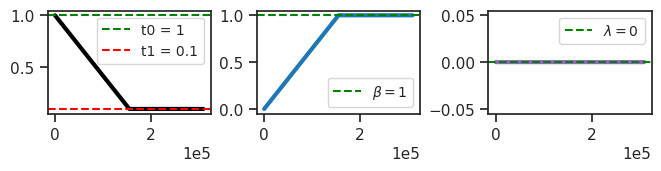

In [7]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

### Fit model

In [8]:
comment = 'NoWhiten'
tr.train(fit_name=f"{comment}_{tr.cfg.name()}")

epoch # 1583, avg loss: 43.426197:  53%|██████████████████████████▉                        | 1583/3000 [3:23:12<2:11:01,  5.55s/it]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



### Loss

In [9]:
data, loss, etc = tr.validate(full_data=True)
kl_diag = loss['kl_diag'][-1]
order = np.argsort(kl_diag)
loss = {
    k: np.mean(v) for k, v in
    loss.items() if k != 'kl_diag'
}
print(loss)

{'kl': 14.01948, 'recon': 30.749651, 'nelbo': 44.76913}

In [7]:
### --> Was whitened

{'kl': 32.559624, 'recon': 135.8825, 'nelbo': 168.44212}

### Visualize

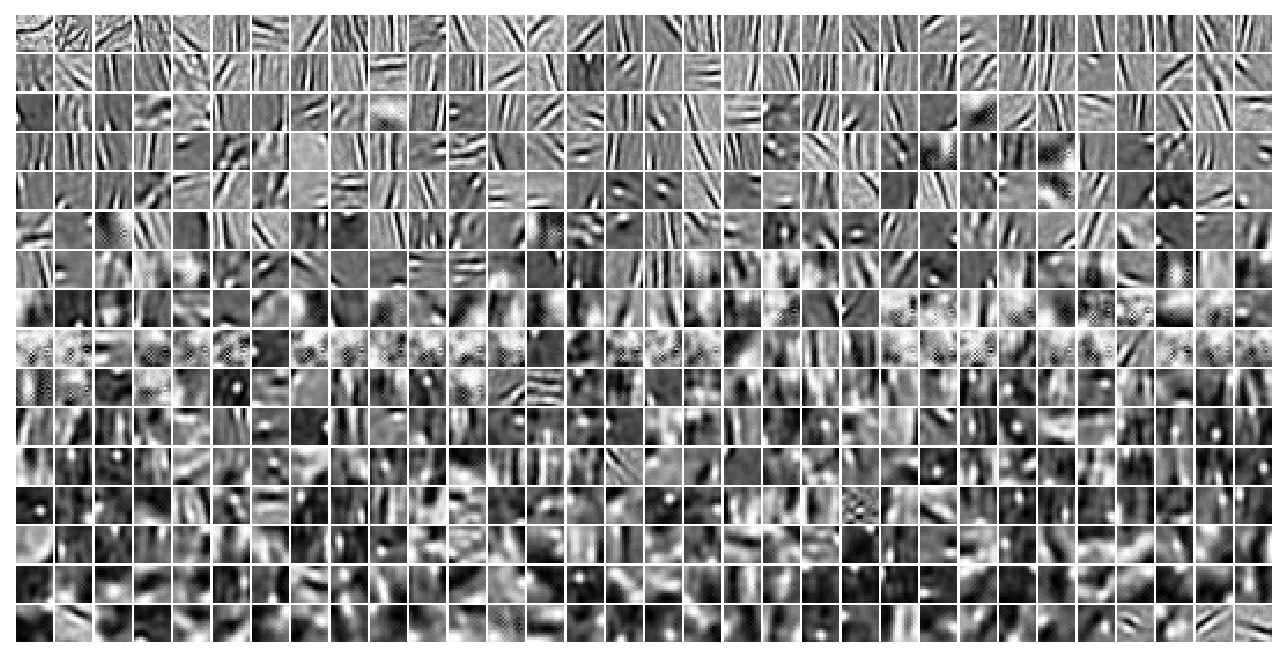

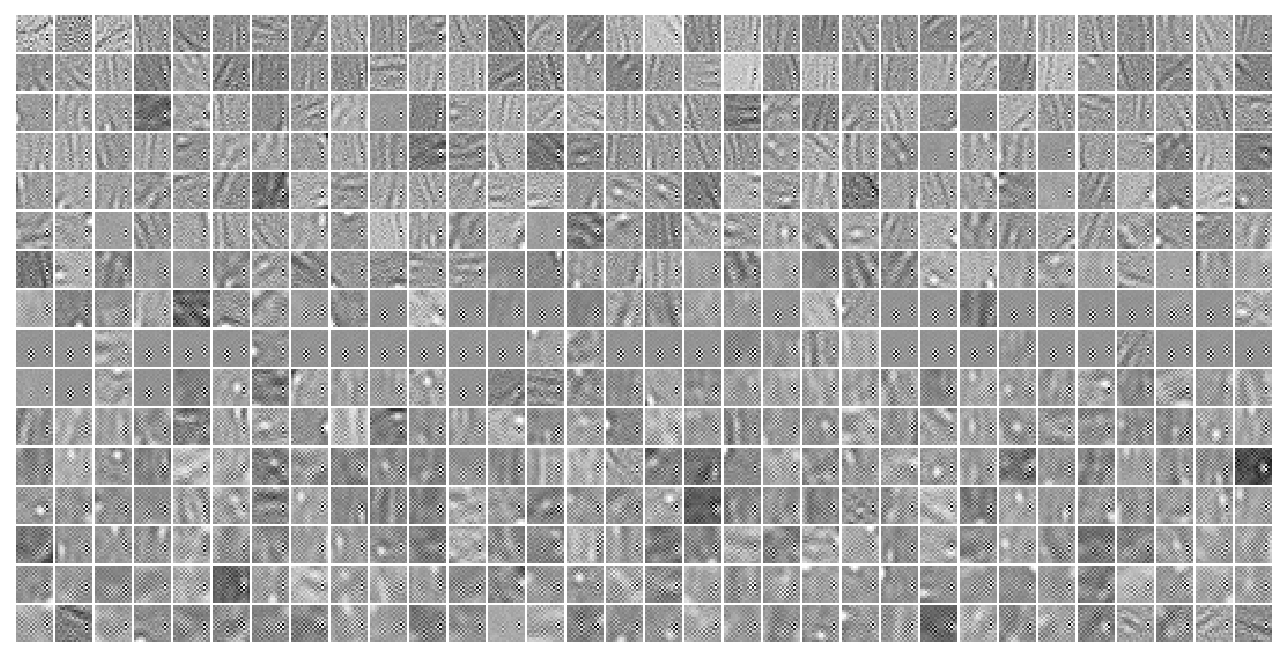

In [10]:
tr.model.show('phi', order=order)
tr.model.show('proj', order=order);

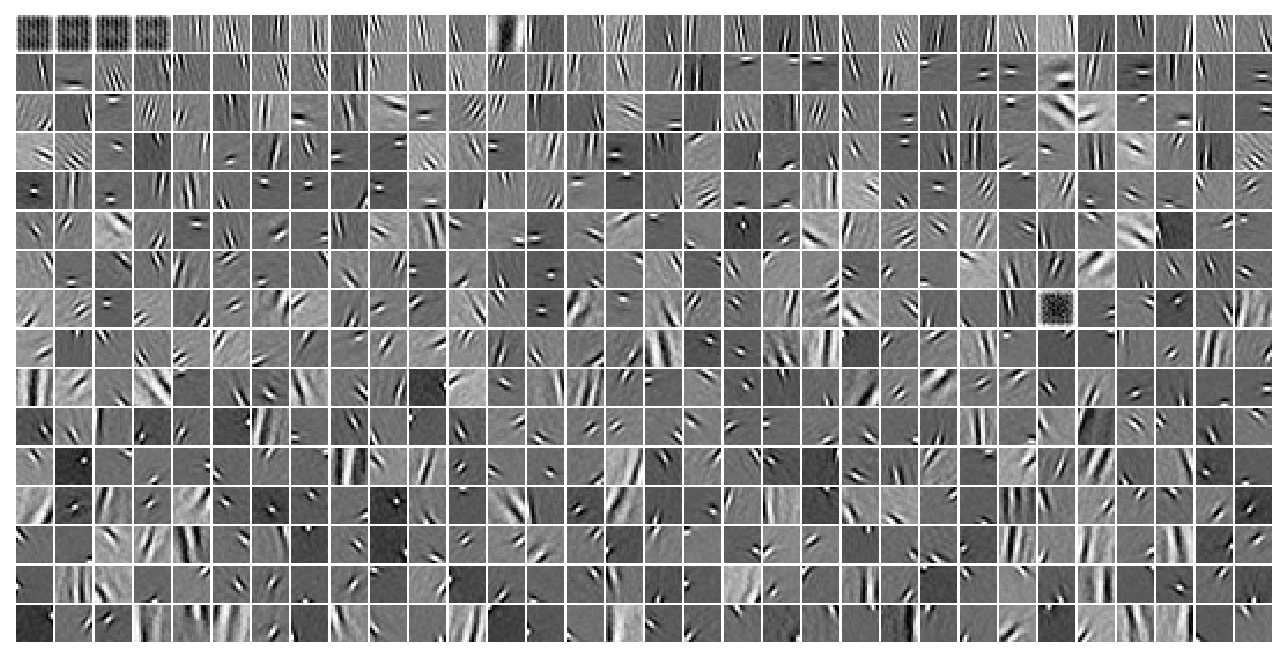

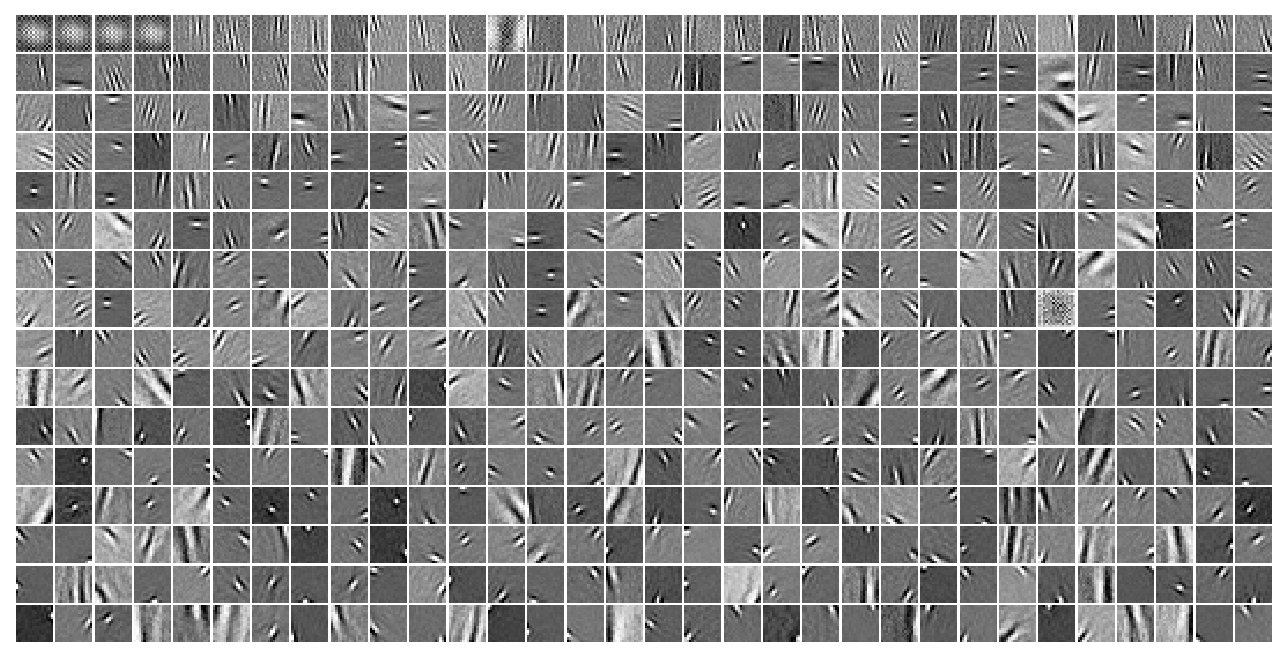

In [9]:
### --> Was whitened